In [1]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
sys.path.append("../")

In [2]:
cancer_num_inputs = 30
cancer_num_outputs = 1


avg_weights_differences = {}
valid_sizes = {}
distances = {}
original_distances = {}
closer = {}

for mlp in Path("../../outputs/cancer/ce").glob("mlp_*.npz"):
    size = tuple(int(s) for s in mlp.stem.split("_")[1:])
    
    data = np.load(mlp)

    avg_weights_differences[size] = data["differences"]
    valid_sizes[size] = data["valids"]
    distances[size] = data["distances"]
    closer[size] = distances[size] < data["original_distances"]
    original_distances[size] = data["original_distances"]


In [3]:
def num_edges(size):

    size = list(size)
    size.insert(0, cancer_num_inputs)
    size.append(cancer_num_outputs)

    return sum(size[i] * size[i + 1] for i in range(len(size) - 1))

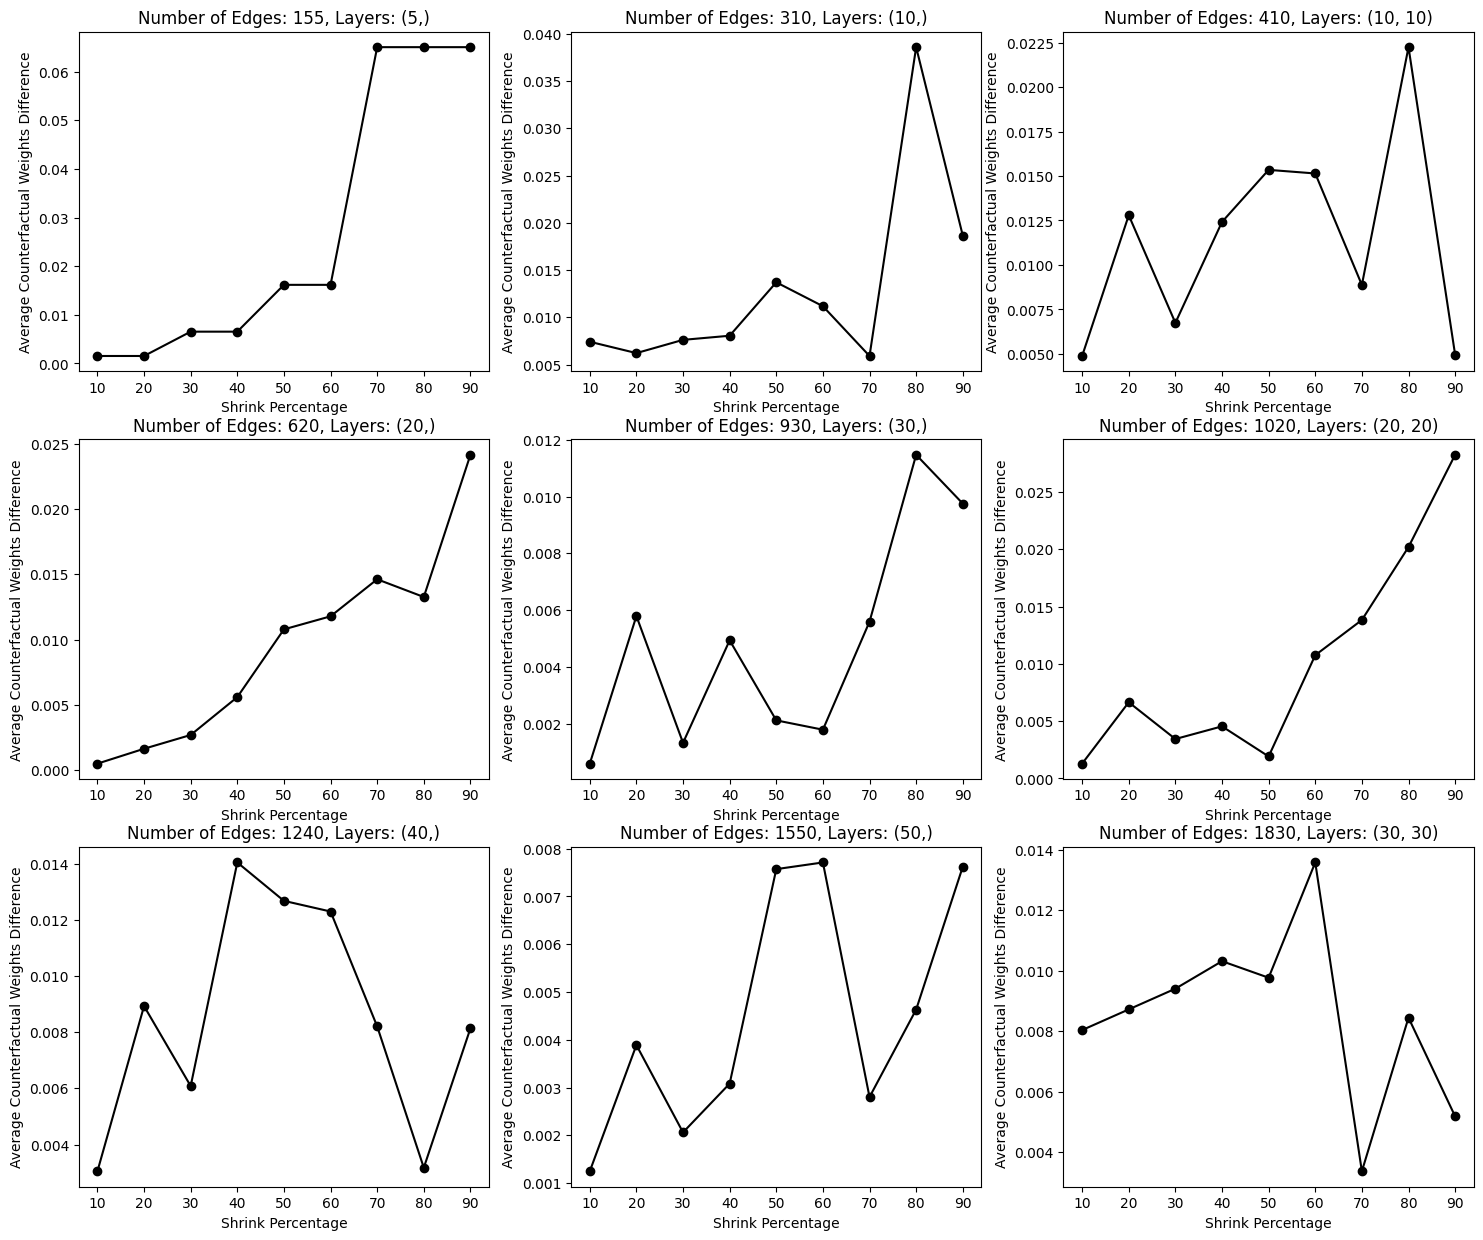

In [4]:
shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]

num_results = len(avg_weights_differences)
cols = min(4, math.ceil(math.sqrt(num_results)))
rows = math.ceil(num_results / cols)

fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

for i in range(rows):
    for j in range(cols):
        ax[i, j].set_axis_off()

avg_weights_differences = dict(sorted(avg_weights_differences.items(), key=lambda x: num_edges(x[0])))

for i, size in enumerate(avg_weights_differences):

    ax[i//cols, i%cols].set_axis_on()
    
    avg = np.mean(avg_weights_differences[size], axis=0)
    # ax[i//cols, i%cols].plot(shrink_percentages, avg)
    ax[i//cols, i%cols].plot(shrink_percentages, avg, marker="o", color="black")
    ax[i//cols, i%cols].set_title(f"Number of Edges: {num_edges(size)}, Layers: {size}")
    ax[i//cols, i%cols].set_xlabel("Shrink Percentage")
    ax[i//cols, i%cols].set_ylabel("Average Counterfactual Weights Difference")
    ax[i//cols, i%cols].set_xticks(shrink_percentages)

In [5]:
# Compute the mean of each array in valid_sizes over axis=0 and create a DataFrame
valid_means = {k: v.mean(axis=0) for k, v in valid_sizes.items()}
valid_df = pd.DataFrame.from_dict(valid_means, orient="index", columns=shrink_percentages)
valid_df.aggregate(["mean"]) * 100

,10,20,30,40,50,60,70,80,90
mean,1.754386,4.678363,3.703704,2.826511,9.746589,7.797271,10.331384,25.82846,26.023392


In [6]:
closer_means = {k: v.mean(axis=0) for k, v in closer.items()}
closer_df = pd.DataFrame.from_dict(closer_means, orient="index", columns=shrink_percentages)
closer_df.aggregate(["mean"]) * 100

,10,20,30,40,50,60,70,80,90
mean,96.588694,96.881092,97.076023,97.368421,97.563353,97.465887,97.563353,98.34308,98.927875


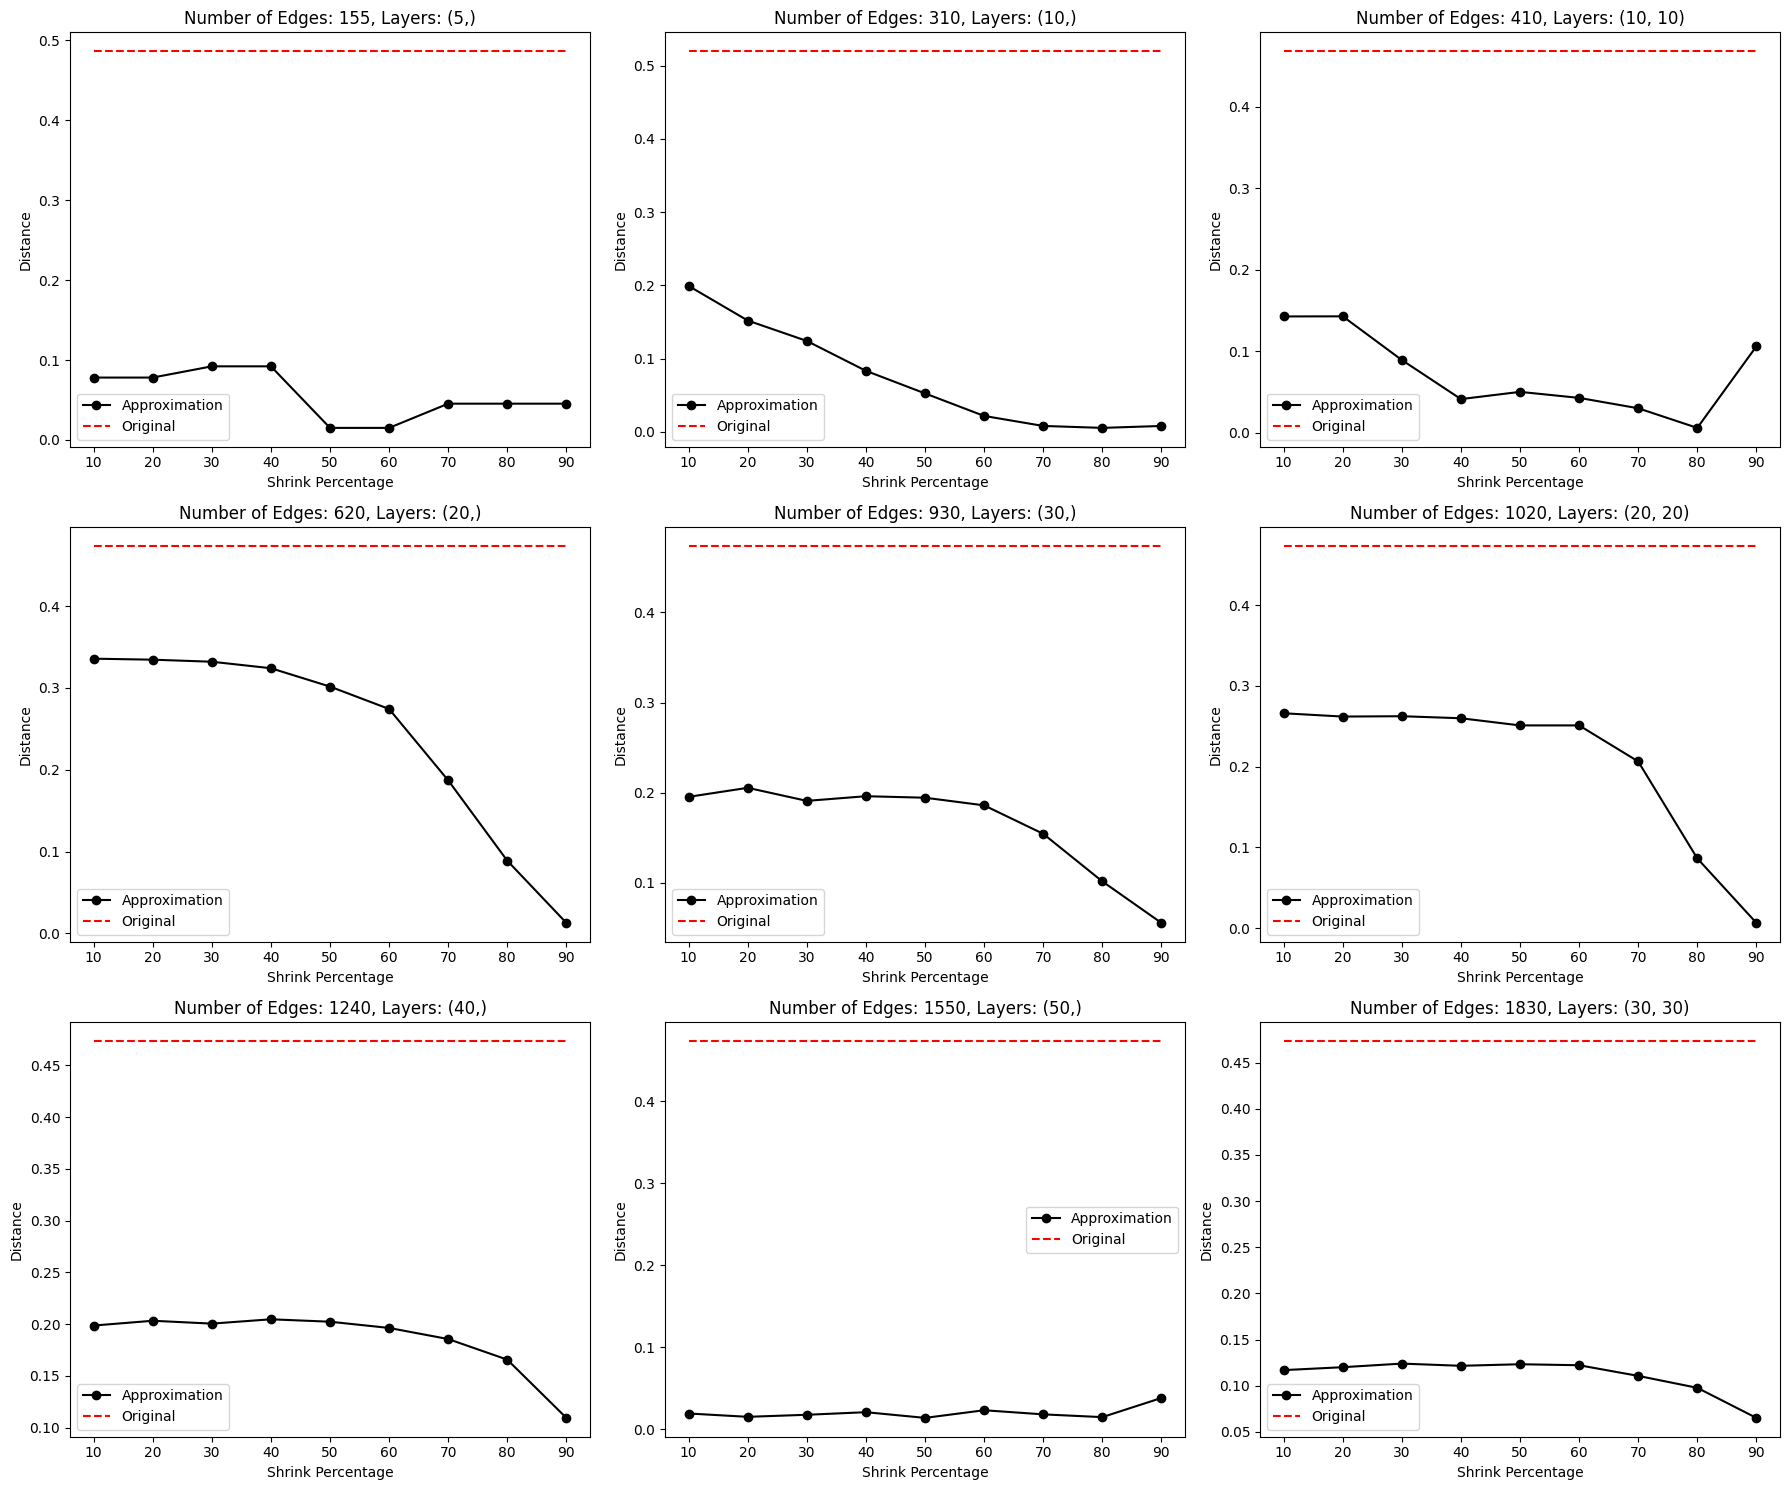

In [ ]:
shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]

num_results = len(distances)
cols = min(4, math.ceil(math.sqrt(num_results)))
rows = math.ceil(num_results / cols)

fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

for i in range(rows):
    for j in range(cols):
        ax[i, j].set_axis_off()

distances = dict(sorted(distances.items(), key=lambda item: num_edges(item[0])))

for i, size in enumerate(distances):
    
    ax[i//cols, i%cols].set_axis_on()
    
    avg = np.mean(distances[size], axis=0)
    avg_original = np.mean(original_distances[size], axis=0)
    # ax[i//cols, i%cols].plot(shrink_percentages, avg)
    ax[i//cols, i%cols].plot(shrink_percentages, avg, marker="o", color="black", label="Approximation")
    ax[i//cols, i%cols].plot(shrink_percentages, avg_original, color="red", label="Original", linestyle="--")
    ax[i//cols, i%cols].set_title(f"Number of Edges: {num_edges(size)}, Layers: {size}")
    ax[i//cols, i%cols].set_xlabel("Shrink Percentage")
    ax[i//cols, i%cols].set_ylabel("Distance")
    ax[i//cols, i%cols].set_xticks(shrink_percentages)

    ax[i//cols, i%cols].legend()

fig.tight_layout()
# fig.savefig("all_distances_cancer.png")

In [8]:
runtime_sparse = {}
runtime_original = {}
sparse_quicker = {}

for mlp in Path("../../outputs/cancer/ce").glob("runtime*.npz"):
    size = tuple(int(s) for s in mlp.stem.split("_")[2:])
    
    data = np.load(mlp)

    print(size)

    runtime_sparse[size] = data["timings_sparse"]
    runtime_original[size] = data["timings_original"]
    sparse_quicker[size] = data["timings_sparse"] < data["timings_original"]

(40,)
(5,)
(50,)
(10,)
(30,)
(20,)
(10, 10)
(30, 30)
(20, 20)


In [9]:
# Compute the mean of each array in valid_sizes over axis=0 and create a DataFrame
quicker_means = {k: v.mean(axis=0) for k, v in sparse_quicker.items()}
quicker_df = pd.DataFrame.from_dict(quicker_means, orient="index", columns=shrink_percentages)
quicker_df

,10,20,30,40,50,60,70,80,90
"(40,)",0.122807,0.166667,0.491228,0.587719,0.649123,0.710526,0.745614,0.666667,0.850877
"(5,)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(50,)",0.289474,0.736842,0.657895,0.640351,0.868421,0.842105,0.903509,0.921053,0.850877
"(10,)",0.000000,0.000000,0.000000,0.000000,0.026316,0.070175,0.122807,0.228070,0.228070
"(30,)",0.675439,0.657895,0.807018,0.833333,0.859649,0.789474,0.929825,0.912281,0.938596
"(20,)",0.105263,0.026316,0.008772,0.254386,0.324561,0.333333,0.412281,0.456140,0.447368
"(10, 10)",0.000000,0.000000,0.000000,0.000000,0.017544,0.008772,0.061404,0.035088,0.043860
"(30, 30)",0.578947,0.745614,0.894737,0.912281,0.912281,0.921053,0.929825,0.938596,0.947368
"(20, 20)",0.140351,0.456140,0.526316,0.473684,0.543860,0.684211,0.657895,0.675439,0.657895


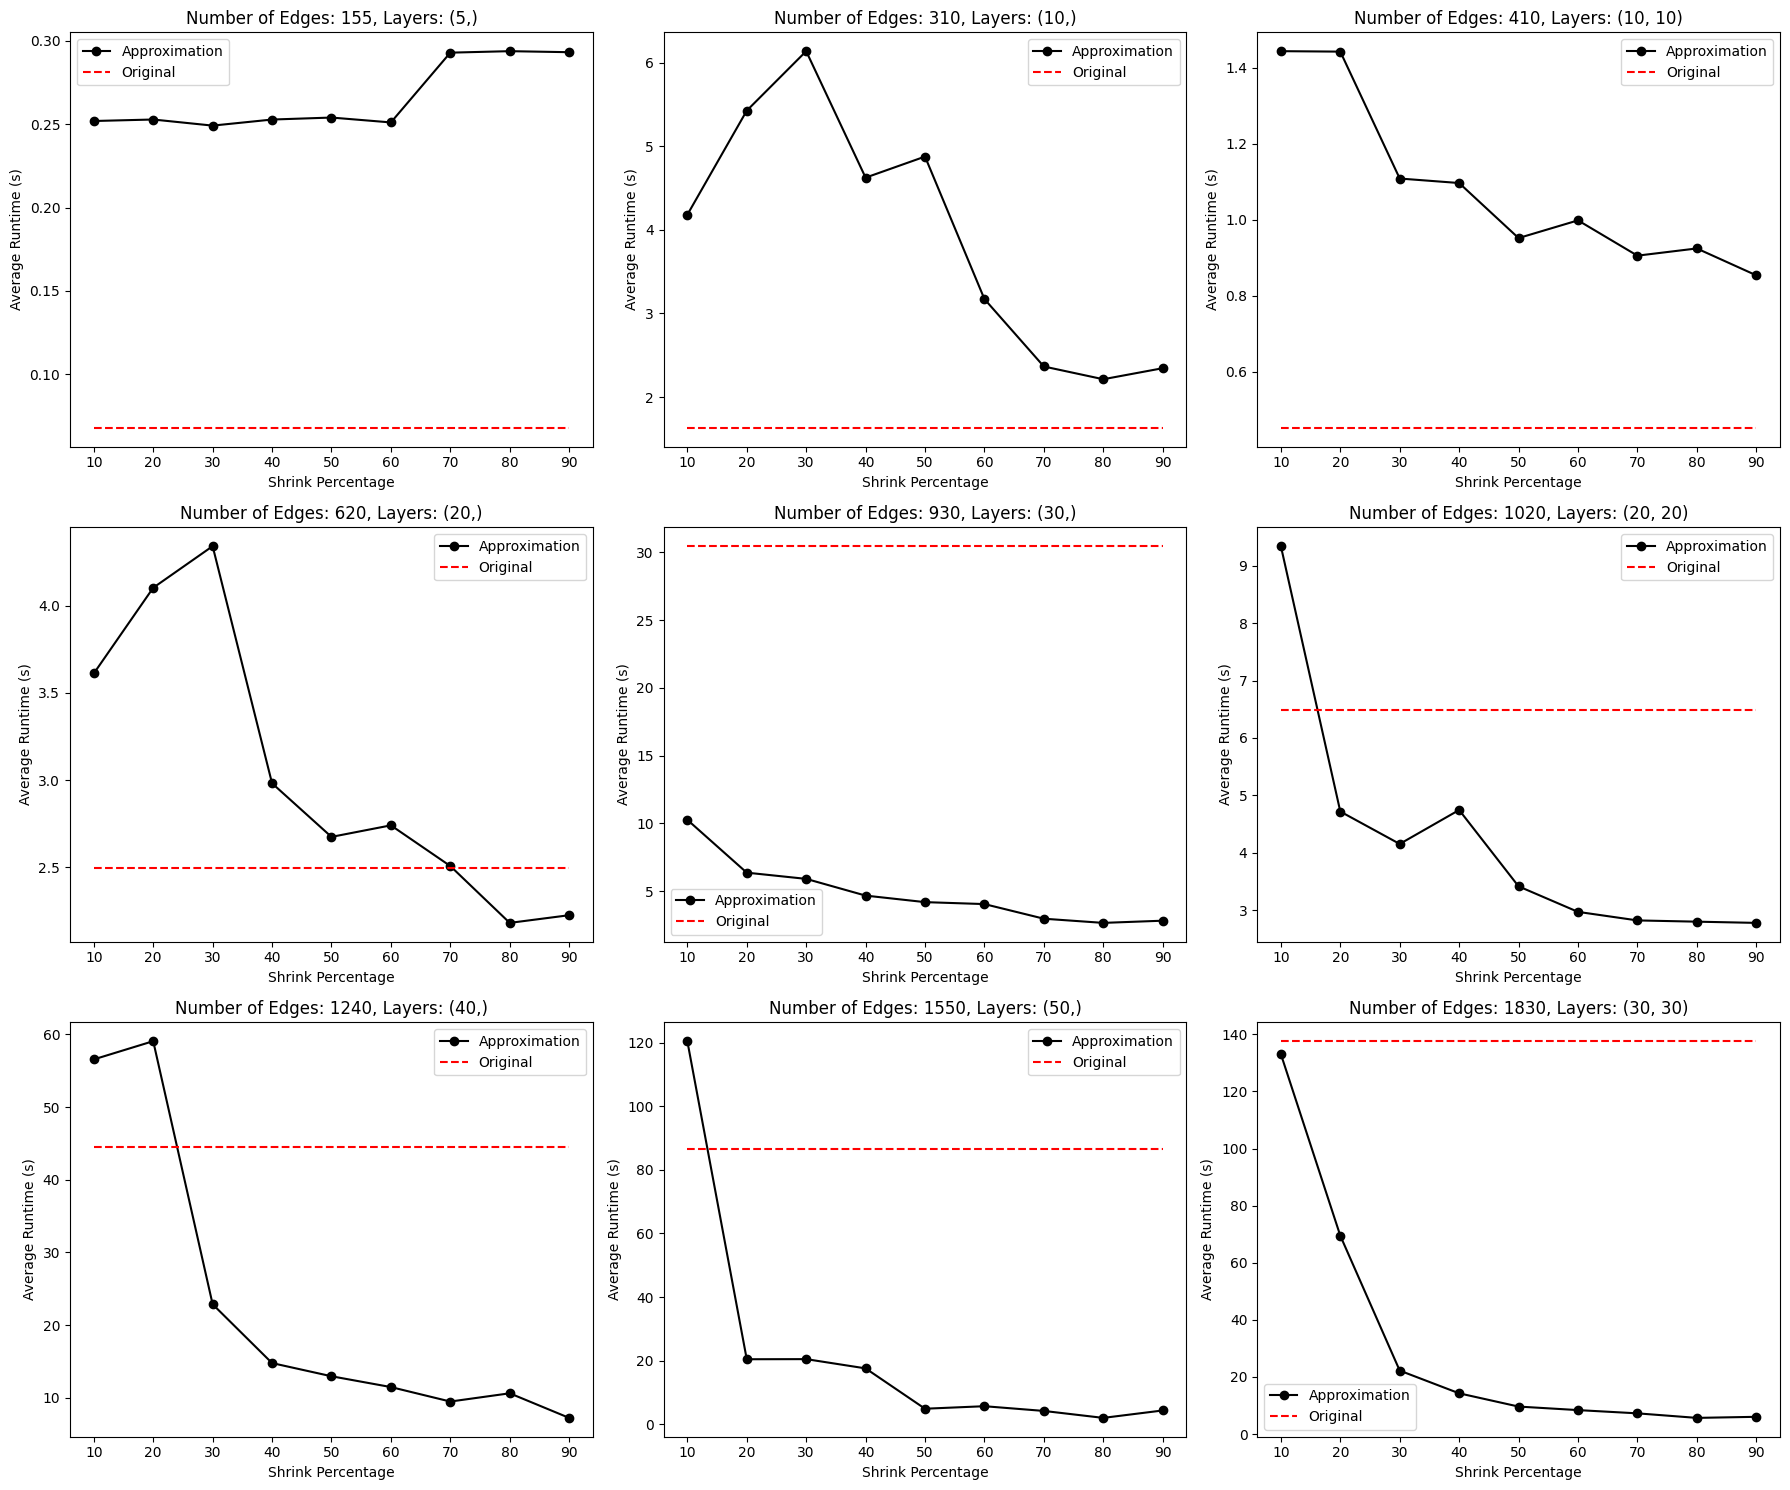

In [ ]:
shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]

num_results = len(runtime_sparse)
cols = min(4, math.ceil(math.sqrt(num_results)))
rows = math.ceil(num_results / cols)

fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

for i in range(rows):
    for j in range(cols):
        ax[i, j].set_axis_off()

runtime_sparse = dict(sorted(runtime_sparse.items(), key=lambda x: num_edges(x[0])))
for i, size in enumerate(runtime_sparse):
    
    ax[i//cols, i%cols].set_axis_on()
    
    avg = np.mean(runtime_sparse[size], axis=0)
    avg_original = np.mean(runtime_original[size], axis=0)
    # ax[i//cols, i%cols].plot(shrink_percentages, avg)
    ax[i//cols, i%cols].plot(shrink_percentages, avg, marker="o", color="black", label="Approximation")
    ax[i//cols, i%cols].plot(shrink_percentages, avg_original, color="red", label="Original", linestyle="--")
    ax[i//cols, i%cols].set_title(f"Number of Edges: {num_edges(size)}, Layers: {size}")
    ax[i//cols, i%cols].set_xlabel("Shrink Percentage")
    ax[i//cols, i%cols].set_ylabel("Average Runtime (s)")
    ax[i//cols, i%cols].set_xticks(shrink_percentages)
    ax[i//cols, i%cols].legend()

fig.tight_layout()
# fig.savefig("all_runtime_cancer.png")

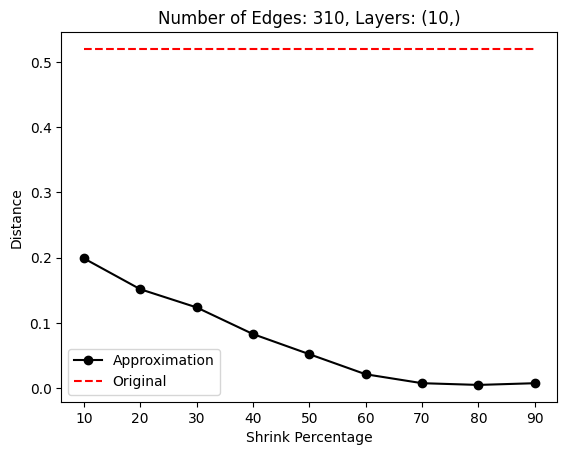

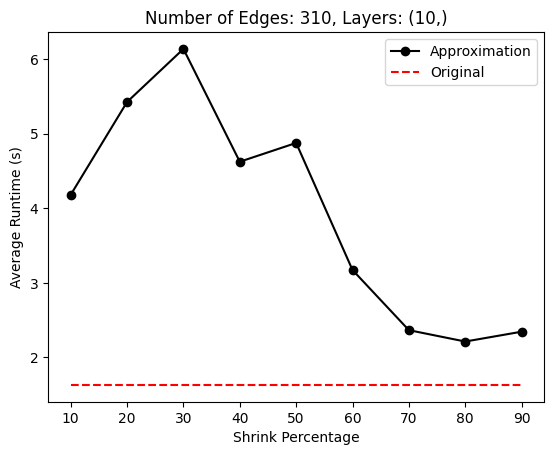

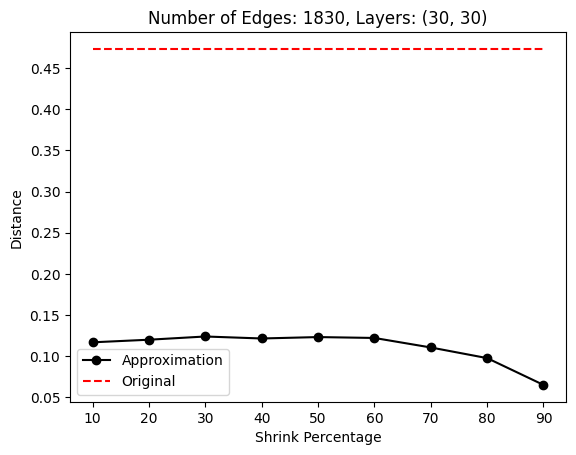

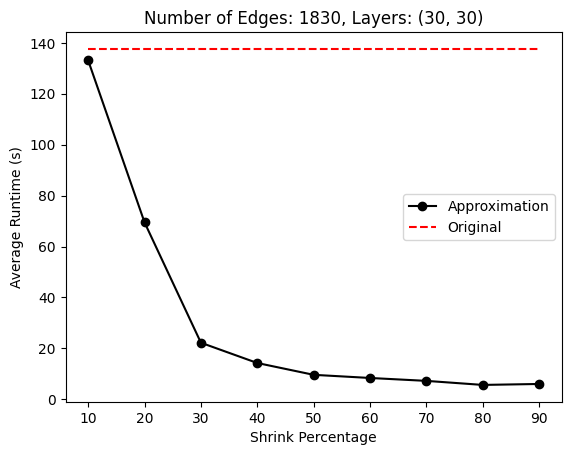

In [11]:
# Diagrams for the report

shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]

size = (10,)
avg = np.mean(distances[size], axis=0)
avg_original = np.mean(original_distances[size], axis=0)
# ax[i//cols, i%cols].plot(shrink_percentages, avg)
plt.plot(shrink_percentages, avg, marker="o", color="black", label="Approximation")
plt.plot(shrink_percentages, avg_original, color="red", label="Original", linestyle="--")
plt.title(f"Number of Edges: {num_edges(size)}, Layers: {size}")
plt.xlabel("Shrink Percentage")
plt.ylabel("Distance")
plt.xticks(shrink_percentages)
plt.legend()
# plt.savefig("approximation_distance_10_cancer.png")
plt.show()

avg = np.mean(runtime_sparse[size], axis=0)
avg_original = np.mean(runtime_original[size], axis=0)
# ax[i//cols, i%cols].plot(shrink_percentages, avg)
plt.plot(shrink_percentages, avg, marker="o", color="black", label="Approximation")
plt.plot(shrink_percentages, avg_original, color="red", label="Original", linestyle="--")
plt.title(f"Number of Edges: {num_edges(size)}, Layers: {size}")
plt.xlabel("Shrink Percentage")
plt.ylabel("Average Runtime (s)")
plt.xticks(shrink_percentages)
plt.legend()
# plt.savefig("approximation_runtime_10_cancer.png")
plt.show()

size = (30,30)
avg = np.mean(distances[size], axis=0)
avg_original = np.mean(original_distances[size], axis=0)
# ax[i//cols, i%cols].plot(shrink_percentages, avg)
plt.plot(shrink_percentages, avg, marker="o", color="black", label="Approximation")
plt.plot(shrink_percentages, avg_original, color="red", label="Original", linestyle="--")
plt.title(f"Number of Edges: {num_edges(size)}, Layers: {size}")
plt.xlabel("Shrink Percentage")
plt.ylabel("Distance")
plt.xticks(shrink_percentages)
plt.legend()
# plt.savefig("approximation_distance_3030_cancer.png")
plt.show()

avg = np.mean(runtime_sparse[size], axis=0)
avg_original = np.mean(runtime_original[size], axis=0)
# ax[i//cols, i%cols].plot(shrink_percentages, avg)
plt.plot(shrink_percentages, avg, marker="o", color="black", label="Approximation")
plt.plot(shrink_percentages, avg_original, color="red", label="Original", linestyle="--")
plt.title(f"Number of Edges: {num_edges(size)}, Layers: {size}")
plt.xlabel("Shrink Percentage")
plt.ylabel("Average Runtime (s)")
plt.xticks(shrink_percentages)
plt.legend()
# plt.savefig("approximation_runtime_3030_cancer.png")
plt.show()
